In [20]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)
import seaborn as sns

In [21]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

In [22]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

data = pd.read_csv('processed_data/train_norm_zero').reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)
#x =  data.drop(columns=['class' , 'src_n' ,'src_id' ,'significance'])
x = data.copy().reset_index(drop=True)
y = data['class'].reset_index(drop=True)
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)
id_train = x_train['src_id'].reset_index(drop=True)
id_test = x_test['src_id'].reset_index(drop=True)
n_train = x_train['src_n'].reset_index(drop=True)
n_test = x_test['src_n'].reset_index(drop=True)
y_train_s = x_train['class'].reset_index(drop=True)
y_test_s = x_test['class'].reset_index(drop=True)
x_train = x_train.drop(columns=[ 'index', 'class' , 'src_n' ,'src_id' ,'significance' , 'var_inter_index' , 'var_inter_prob' , 'var_inter_sigma']).reset_index(drop=True)
x_test = x_test.drop(columns=[ 'index', 'class' , 'src_n' ,'src_id' ,'significance' , 'var_inter_index' , 'var_inter_prob' , 'var_inter_sigma']).reset_index(drop=True)

clf = RandomForestClassifier(n_estimators=300 ,random_state=1)
clf.fit(x_train, y_train)
test_score = clf.score(x_test , y_test)
train_score =clf.score(x_train , y_train)
print(train_score)
print(test_score)





1.0
0.9021739130434783


In [23]:
test_score = clf.score(x_test , y_test)
print(test_score)

0.9021739130434783


In [24]:
cf = confusion_matrix(y_test , clf.predict(x_test))
print(cf)

[[27  5]
 [ 4 56]]


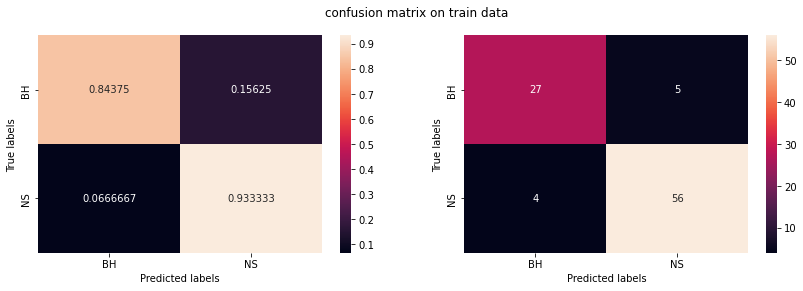

In [25]:
c = np.asarray([[ci /sum(c_row) for ci in c_row] for c_row in cf])
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(14,4)) 
#ax = 
sns.heatmap(c, annot=True, fmt='g', ax=ax[0]);  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cf, annot=True, fmt='g', ax=ax[1]); 
# labels, title and ticks
for a in ax:
    a.set_xlabel('Predicted labels')
    a.set_ylabel('True labels')
    #ax[0].set_title('Confusion Matrix Test Data'); 
    a.xaxis.set_ticklabels([ 'BH' , 'NS' ]) 
    a.yaxis.set_ticklabels(['BH', 'NS'])
plt.suptitle('confusion matrix on train data')
#plt.savefig('pred_result/plots/cf_ns_bh_train.jpg')
plt.show()
plt.close()

## Feature Importance

In [29]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False)
feat_names_sorted = feat['feat_name']
display(feat)

,feat_name,feat_imp
16,photflux_aper_hilim_u,0.037997
17,photflux_aper_hilim_m,0.036070
3,flux_aper_hilim_h,0.035332
1,flux_aper_hilim_u,0.032695
15,photflux_aper_hilim_s,0.030688
...,...,...
68,flux_bb_lolim,0.000483
61,powlaw_nh_lolim,0.000468
66,flux_bb,0.000443
73,bb_nh_lolim,0.000411


## Prepare result for analysis

In [30]:
def create_res_data(x , y , id , n , cl_type):
    pred = clf.predict(x)
    pred_prob = clf.predict_proba(x)
    pred_prob = [np.amax(pi) for pi in pred_prob]

    res =  x[feat_names_sorted].copy().reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(0 , 'src_id' , id)
    res.insert(1, 'src_n' , n)
    res.insert(2 , 'true_class' , y)
    res.insert(3 ,'pred_class' , pred)
    res.insert(4 , 'pred_prob' , pred_prob)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    display(res)
    return res

train_res = create_res_data(x_train , y_train_s , id_train , n_train , cl_type='train')
test_res = create_res_data(x_test , y_test_s , id_test , n_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')

,src_id,src_n,true_class,pred_class,pred_prob,th_class,is_ok,truth,clf_type,photflux_aper_hilim_u,...,brems_nh,powlaw_stat,flux_powlaw,bb_nh,brems_nh_hilim,flux_bb_lolim,powlaw_nh_lolim,flux_bb,bb_nh_lolim,flux_powlaw_lolim
0,NS0044,XMMU J004245.2+41172,NS,NS,0.996667,NS,1,1,train,0.828606,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,NS0078,1WGA J1911.2+0035,NS,NS,0.996667,NS,1,1,train,0.455007,...,0.032615,0.162005,0.20672,0.02331,0.030935,0.180444,0.03889,0.195832,0.020375,0.199992
2,NS0044,XMMU J004245.2+41172,NS,NS,0.980000,NS,1,1,train,0.776002,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,NS0071,SAXWFC J1748.1-2446.,NS,NS,0.923333,NS,1,1,train,0.176244,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,NS0046,XMMU J004245.2+41172,NS,NS,0.950000,NS,1,1,train,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,BH0021,CXOU J100516.5-07420,BH,BH,0.873333,BH,1,1,train,0.014854,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
364,BH0018,CXOU J100514.2-07423,BH,BH,0.983333,BH,1,1,train,0.235827,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
365,NS0057,J1748-2446,NS,NS,0.910000,NS,1,1,train,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
366,NS0020,EXO 1745-248,NS,NS,0.900000,NS,1,1,train,0.368067,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


,src_id,src_n,true_class,pred_class,pred_prob,th_class,is_ok,truth,clf_type,photflux_aper_hilim_u,...,brems_nh,powlaw_stat,flux_powlaw,bb_nh,brems_nh_hilim,flux_bb_lolim,powlaw_nh_lolim,flux_bb,bb_nh_lolim,flux_powlaw_lolim
0,NS0001,1A 1742-289,NS,NS,0.880000,NS,1,1,test,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,NS0066,SAXWFC J1734.2-2605.,NS,NS,0.503333,X,1,2,test,0.167214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,NS0046,XMMU J004245.2+41172,NS,NS,0.570000,X,1,2,test,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,BH0018,CXOU J100514.2-07423,BH,BH,0.920000,BH,1,1,test,0.290069,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,NS0021,GRS 1741.9-2853,NS,NS,0.880000,NS,1,1,test,0.784249,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,NS0001,1A 1742-289,NS,NS,0.743333,X,1,2,test,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
88,BH0027,J1745-2900,BH,BH,0.810000,BH,1,1,test,0.557178,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
89,BH0027,J1745-2900,BH,BH,0.696667,X,1,2,test,0.439239,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
90,NS0072,SAXWFC J1748.1-2446.,NS,NS,0.706667,X,1,2,test,0.277570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [31]:
res_data = pd.concat([train_res , test_res]).reset_index(drop=True)
res_data.to_csv('result/res_data_all_zero_impute.csv')